## Deep Learning: Comparison of MLP and CNN

**Name: Elise Rattigan**<br>
**Last modified:** August 2021<br>

This project is adapted from one of the assignments in my Machine Learning unit at university, for which I received a mark of 100%.

This was a large project involving deep learning on the **CIFAR-10** dataset. This dataset contains a large number of 32 x 32 colour images which are divided into 10 classes. The data provided to us was already split into a training set, with 6,000 images per class, and a test set of 10,000 instances.

The purpose of this project was to train both a **Multi-Layer Perceptron (MLP)** and a **Convolutional Neural Network (CNN)** and compare their performance against each other.

In this notebook, I will be training the two models, using some experimentation to find optimal values for some of the hyperparameters. Not all of the experimentation code is contained in this notebook, and I have removed some of the detailed descriptions which were specifically required for the original assignment.

After training the models, I will be evaluating their performance at predicting the classes of the test data, and displaying some correct and incorrect classifications as images with class labels. I will then compare the performance of the two models, looking specifically at accuracy, confusion matrices and performance on specific classes.

**Note**: The data files for this project were too large to upload to GitHub. If you wish to run the notebook, you will need to download the data files from the link here: [(https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)].

In [1]:
# Standard imports
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow import keras

# Scikit-Learn metrics
from sklearn.metrics import f1_score, confusion_matrix

## 1. Data Loading

To load the data, a `data_loader.py` file was supplied to us, which contains functions to read in the data from the batch files. The code below calls these functions and loads the data.

In [3]:
# Import the DataLoader class
from data_loader import DataLoader

# According to the CIFAR-10 website, the training set is split into five batches
# stored in fives files. Each colour image has dimensions equal to 32 x 32 x 3. There
# are 10 classes.
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# The default values of all the arguments of the load_batch function have been
# set for the CIFAR-10 dataset.
X_train, y_train = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

In [4]:
# Quick inspection of the training and test sets
print('X_train.shape =', X_train.shape, 'data type:', X_train.dtype)
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)

X_train.shape = (50000, 32, 32, 3) data type: float32
X_test.shape = (10000, 32, 32, 3) data type: float32


The imported dataset had already been split into a training and test set, and the shapes of these two sets are displayed in the output above. I will now also create a validation set.  I will do this by splitting the training set in an 80/20 split with the `train_test_split` function from Scikit-Learn.

In [5]:
# Random seed for reproducibility
np.random.seed(100)

# Split training data 80/20 to form validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2) # 80/20 split

In [6]:
print('X_train.shape =', X_train.shape, 'data type:', X_train.dtype)
print('X_valid.shape =', X_valid.shape, 'data type:', X_valid.dtype)

X_train.shape = (40000, 32, 32, 3) data type: float32
X_valid.shape = (10000, 32, 32, 3) data type: float32


The above output shows that the training set is now 80% of its original size, and the validation set makes up the other 20%.

## 2. Display images

Before training the models, I will have a look at the images in the dataset to see what I am working with. I have created two functions below, which I will use to display 20 randomly sampled images from each of the training, validation and test sets, with class names included as labels for each image.

The first function below, `plot_images`, takes a list of indexes, the dataset and the labels, and plots the images on 20 subplots with their class names as labels. I have made the figure size quite small, because the images look too pixelated and are hard to see at larger sizes.

The second function, `display_images`, creates the list of indexes by random sampling, which it then passes when it calls the first function to actually display the images. In this way, I am able to create functions which generate different types of index list, and then can call the `plot_images` functions within them without having to repeat my code.

In [1]:
# Function to plot images from a passed dataset
def plot_images(index_list, dataset, labels):
    # Create axes
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(7, 7))
    ax_list = fig.get_axes()

    # Index dataset to get instances, and plot
    for i in range(0, 20, 1):
        idx = index_list[i]
        ax_list[i].imshow(dataset[idx], cmap="binary") # Display image
        ax_list[i].axis('off') # Remove axis
        ax_list[i].set_title(class_names[labels[idx]], fontsize=12) # Add class name as title

    # Return figure object
    return fig

In [8]:
# Function to get 20 random indexes, call plotting function and add plot title
def display_images(dataset, labels, dataset_name):
  
    # Get 20 random integers from array the length of dataset
    index_list = np.random.randint(0, len(dataset), 20)

    # Call figure from plot_images function
    fig = plot_images(index_list, dataset, labels)

    # Create plot title using dataset name
    plot_title = '20 random images from the ' + dataset_name
    fig.suptitle(plot_title, fontsize=16, y=0.95)

    return

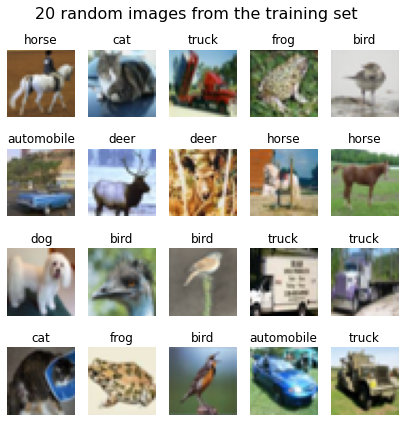

In [9]:
# Call function with training set
display_images(X_train, y_train, 'training set')

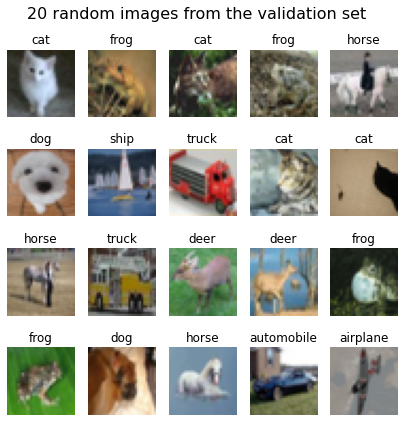

In [10]:
# Call function with validation set
display_images(X_valid, y_valid, 'validation set')

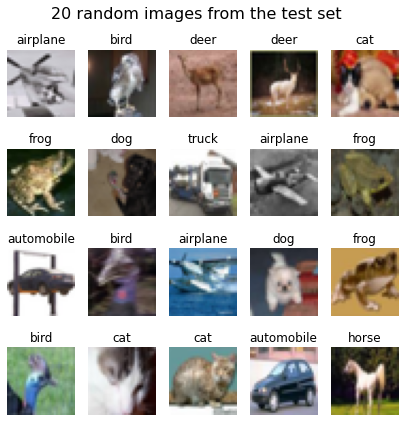

In [11]:
# Call function with test set
display_images(X_test, y_test, 'test set')

## 3. Implementation of an MLP

The first model I will train is a Multi-Layer Perceptron (MLP). There are a number of possible hyperparameters which can be experimented with to optimise the model. To do this, I will be using **Keras Tuner**, a Keras library which works similarly to GridSearchCV in Scikit-Learn.  I will use the `Hyperband` tuner, which uses a specific algorithm to quickly converge on the highest-performing models.

Keras Tuner allows you to pass in the **validation set** as an argument, to score the models by **validation accuracy**, rather than training accuracy. Then you can choose the best model by validation accuracy, which is more representative of how well the model will perform on unseen data.

**Note**: Not shown in this notebook is a rather extensive experimentation process I went through, testing multiple values for each hyperparameter, one at a time. The Keras Tuner search shown below is a final search, with just a couple of values for each hyperparameter, to try and end up with the best combination of values.

There were also a few hyperparameters which I decided to keep at fixed values during experimentation and for the final model:

* **Number of hidden layers**: I decided on two layers, to minimise the number of trainable parameters in the model and reduce the risk of overfitting the training set.
* **Number of neurons in the hidden layers**: I decided that 300 was a reasonable number to be flexible enough to fit the training data, while keeping the number of trainable parameters down and reducing the risk of overfitting.
* **Loss function**: I used `sparse_categorical_crossentropy` because this is the appropriate loss function to use for sparse labels (i.e. classes 0 to 9), rather than one-hot encoded labels.
* A final output layer with 10 neurons and a `softmax` activation function, because there are 10 classes, and the classes are exclusive.

**Note**: For the original assignment, there were quite a few restrictions imposed, so my experimentation and final model are within those specified limits. It is therefore not likely to be the best possible MLP I could have created.

The final Keras Tuner search is commented out below.

In [12]:
# # Install and import Keras Tuner (for Google Colab)
# !pip install -q -U keras-tuner
# import kerastuner as kt

# # Full Keras tuner search with 2x combinations for dropout and initialisation
# # Define the model builder function
# def model_builder_test1(hp):
  
#   # Two options for dropout rate
#   drop_rate = hp.Choice('drop_rate', [0.0, 0.2])
#   # Two options for connection weight initialisation
#   hp_ki = hp.Choice("kernel_initializer", ["he_normal", "glorot_uniform"])

#   # Create the model
#   model = keras.models.Sequential([
#           keras.layers.Flatten(input_shape=[32, 32, 3]),
#           keras.layers.Dropout(rate=drop_rate),
#           keras.layers.Dense(units=300, activation="relu", kernel_initializer=hp_ki),
#           keras.layers.Dropout(rate=drop_rate),
#           keras.layers.Dense(units=300, activation="relu", kernel_initializer=hp_ki),
#           keras.layers.Dropout(rate=drop_rate),
#           keras.layers.Dense(units=10, activation="softmax")
#   ])
  
#   # Momentum optimiser
#   opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
#   model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#   return model

# # Create the Hyperband tuner
# tuner_test1 = kt.Hyperband(model_builder_test1,
#                      objective='val_accuracy',
#                      max_epochs=100,
#                      factor=3)

# # Use tuner to search on training set and test on validation set
# tuner_test1.search(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[])

# # Get a summary of top 10 results
# tuner_test1.results_summary()

The results of the above search showed the model with the highest validation accuracy had a `he_normal` connection weight initialisation and a dropout rate of 0.0 (i.e. no dropout).

One more setting I will experiment with is **learning rate scheduling**. To do this, I will run the above Keras Tuner search twice more, each time with a different learning rate scheduler, to see which one makes the biggest improvement to the validation accuracy.

I will try the following two learning rate schedulers:
* A **piecewise constant scheduler**, which uses a constant learning rate for a number of epochs, then a smaller learning rate for the next lot of epochs, then so on.
* A **performance scheduler**, which measures the validation error every N steps, and reduces the learning rate when the error stops dropping. This simply uses the `ReduceLROnPlateau` callback to halve the learning rate whenever the best validation loss does not improve for 5 consecutive epochs.

The functions to create these learning rate schedulers are below, followed by the commented-out Keras Tuner searches.

In [13]:
# Function to create piecewise constant learning rate scheduler
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

# Call function
piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

# Create LearningRateScheduler callback with this schedule
lr_piecewise = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

In [14]:
# Create performance scheduler by using ReduceLROnPlateau callback
lr_performance = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

In [15]:
# # Full Keras tuner search with 2x combinations, piecewise constant scheduler
# def model_builder_test2(hp):

#   # Two options for dropout rate and initialisation
#   drop_rate = hp.Choice('drop_rate', [0.0, 0.2])
#   hp_ki = hp.Choice("kernel_initializer", ["he_normal", "glorot_uniform"])

#   # Create the model
#   model = keras.models.Sequential([
#           keras.layers.Flatten(input_shape=[32, 32, 3]),
#           keras.layers.Dropout(rate=drop_rate),
#           keras.layers.Dense(units=300, activation="relu", kernel_initializer=hp_ki),
#           keras.layers.Dropout(rate=drop_rate),
#           keras.layers.Dense(units=300, activation="relu", kernel_initializer=hp_ki),
#           keras.layers.Dropout(rate=drop_rate),
#           keras.layers.Dense(units=10, activation="softmax")
#   ])
  
#   # Momentum optimiser
#   opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
#   model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#   return model

# # Create the Hyperband tuner
# tuner_test2 = kt.Hyperband(model_builder_test2,
#                      objective='val_accuracy',
#                      max_epochs=100,
#                      factor=3)

# # Use tuner with LearningRateScheduler callback (piecewise constant function)
# tuner_test2.search(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[lr_piecewise])

# # Get a summary of top 10 results
# tuner_test2.results_summary()

In [16]:
# # Full Keras tuner search with 2x combinations, performance scheduler
# def model_builder_test3(hp):

#   # Two options for dropout rate and initialisation
#   drop_rate = hp.Choice('drop_rate', [0.0, 0.2])
#   hp_ki = hp.Choice("kernel_initializer", ["he_normal", "glorot_uniform"])

#   # Create the model
#   model = keras.models.Sequential([
#           keras.layers.Flatten(input_shape=[32, 32, 3]),
#           keras.layers.Dropout(rate=drop_rate),
#           keras.layers.Dense(units=300, activation="relu", kernel_initializer=hp_ki),
#           keras.layers.Dropout(rate=drop_rate),
#           keras.layers.Dense(units=300, activation="relu", kernel_initializer=hp_ki),
#           keras.layers.Dropout(rate=drop_rate),
#           keras.layers.Dense(units=10, activation="softmax")
#   ])
  
#   # Momentum optimiser
#   opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
#   model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

#   return model

# # Create the Hyperband tuner
# tuner_test3 = kt.Hyperband(model_builder_test3,
#                      objective='val_accuracy',
#                      max_epochs=100,
#                      factor=3)

# # Use tuner with LearningRateScheduler callback (performance function)
# tuner_test3.search(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[lr_performance])

# # Get a summary of top 10 results
# tuner_test3.results_summary()

The results of my experimentation showed that the model with the highest validation accuracy has the following hyperparameters:

* Connection weight initialisation: `he_normal`
* Dropout rate: 0.0
* Learning rate scheduler: Performance scheduler

Now that I have the optimal combination of hyperparameters, I can create and train the MLP model. First, I will create two more callbacks:

* An **early stopping callback**, which interrupts training when no progress is observed on the validation set for a certain number of epochs (set by the patience argument)
* A **checkpoint callback**, which I set to `save_best_only=True`, to save the best model from training to my directory.

The code to create these callbacks is shown below.

In [17]:
# Create callbacks
# Early stopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

# Checkpoint callback
checkpoint_mlp = keras.callbacks.ModelCheckpoint("Rattigan_Elise-MLP", save_best_only=True)

### 3.1 Implementing the model

The code to create the model with the optimal hyperparameters is shown below. As already discussed, its settings are:
* Two hidden layers, each with 300 neurons, ReLU activation and `he_normal` connection weight initialisation
* Momentum optimisation (with momentum of 0.9)
* Callbacks for performance scheduling, early stopping and checkpoint

Although a Dropout rate of 0.0 was found to be the best, when I first fit the model, it had a much higher training accuracy than validation accuracy, which suggested it was overfitting. I therefore went back and added in **Dropout** layers with a **rate of 0.1** before each Dense layer, to try and reduce overfitting.

This model then took a **long time to converge**, stopping at the maximum 100 epochs, so I added in **BatchNormalization** layers after each Dropout layer in an attempt to improve performance, and reduced the early stopping patience from 10 to 5. The final model (below) still can take around 50 epochs to converge, but has much less evidence of overfitting.

The model below is enclosed in an **if-else** statement to enable two options for implementation:
* To create and train the model from scratch for 100 epochs, **or**
* If the model directory exists, to load the trained model and train for one more epoch.

The code below also outputs a summary of the model's architecture and (if training the model from scratch) a graph of the learning curves.

In [18]:
# Allowing options to implement model from scratch, or existing model
if os.path.isdir("Rattigan_Elise-MLP"):

    # Load existing model
    mlp = keras.models.load_model("Rattigan_Elise-MLP")

    # Display architecture
    mlp.summary()

    # Train existing model for one more epoch, early stopping callback not required
    history = mlp.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid),
                  callbacks=[checkpoint_mlp, lr_performance])

else:
    # Create the model from scratch
    # Has 2 hidden layers, Dropout and BatchNormalization layers
    mlp = keras.models.Sequential([
            keras.layers.Flatten(input_shape=[32, 32, 3]),
            keras.layers.Dropout(rate=0.1),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
            keras.layers.Dropout(rate=0.1),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
            keras.layers.Dropout(rate=0.1),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(10, activation="softmax")
  ])

    # Display architecture
    mlp.summary()

    # Compile the model with optimizer and loss function explained in tuning section
    opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    mlp.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # Train the model and pass validation set to measure validation accuracy
    # Include early stopping, checkpoint and performance scheduler callbacks
    history = mlp.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
                  callbacks=[early_stopping_cb, checkpoint_mlp, lr_performance])
  
    # Inspect the learning curves
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3072)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               9

From the summary of the architecture in the output, we can that the first hidden layer (Dense layer) has 3072 x 300 connection weights, plus 300 bias terms, making 921,900 parameters in that layer. The second hidden layer has 300 x 300 connection weights (where it is connected to the neurons in the previous layer), plus 300 bias terms.

The **BatchNormalization layers** each add 4 parameters per input, increasing the total number of parameters, but they do act as a **regulariser**, hopefully cancelling out the risk of overfitting from the extra parameters.

When the model is trained from scratch, the output shows the training and validation loss and accuracy scores at each epoch. The loss is the error function which we are trying to minimise, because the smaller the loss, the closer the predictions are to the true labels. Loss should decrease with each epoch as the model converges. The final epoch is not necessarily the best, but because of the checkpoint callback I used, the model with the **best validation accuracy** is the one which is **saved to the directory**.

In the final few epochs, the validation accuracy is quite close to the training accuracy, which is a good sign that the model is not overfitting the training data too much.

### 3.2 Evaluating the model

Now that the model is trained, I can use it to make predictions on the test set, calculate the accuracy and F1 score and produce confusion matrices of the correct and incorrect classifications.

The below function accepts the model as an argument and predicts the classes of the test set instances.  Accuracy is calculated through the Keras `evaluate()` method.

From Keras version 2.0 onwards, the F1 score metric has been removed, so I can't use a straightforward Keras function to calculate F1 score. Instead, I will use Scikit-Learn for this calculation, with a `micro` average, which calculates a global average across all the predictions for every class.

In [19]:
def get_scores(model, model_name):

    # Get predictions on test set
    y_pred = np.argmax((model.predict(X_test) > 0.5).astype("int32"), axis=-1)

    # Use Keras evaluate method to get accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
  
    # Use sklearn metrics to get F1 score
    f1 = round(f1_score(y_test, y_pred, average='micro'), 3)

    # Print scores
    print('The classification accuracy of the {} on the test set is {}.'.format(model_name, round(accuracy, 3)))
    print('The average F1 score of the {} on the test set is {}.'.format(model_name, f1))

    return y_pred, accuracy, f1

In [20]:
# Apply function to MLP model
y_pred_mlp, accuracy_mlp, f1_mlp = get_scores(mlp, 'MLP')

The classification accuracy of the MLP on the test set is 0.566.
The average F1 score of the MLP on the test set is 0.476.


The scores can vary each time the model is run, but in general, the **accuracy score** on the test set is around **0.55**. This means the model is only getting 55% of the predictions correct.

The **F1 score**, which is the harmonic mean of precision and recall, is around **0.45**. This means that the precision and recall average out to about 45%.

However, there are 10 classes in the data, so one would expect random guessing to achieve about 10% accuracy. So the model is doing a lot better than random guessing, but there is still room for improvement.

The below function displays a confusion matrix of the model's prediction on the test set. This function accepts the model as an argument and uses the `heatmap` plot from Seaborn to create the confusion matrix.

In [21]:
def show_confusion_matrix(model, y_pred, model_name, colour):
  
    # Create confusion matrix on test set
    confusion = confusion_matrix(y_test, y_pred)

    # Define figure size
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot confusion matrix with integer formatting
    sns.heatmap(confusion, cmap=colour, annot=True, fmt='d', ax=ax)

    # Set axis and plot labels
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names, rotation=0)
    title = model_name + ' confusion matrix on test set'
    ax.set(title=title,
           xlabel="Predicted label",
           ylabel="True label");

    return

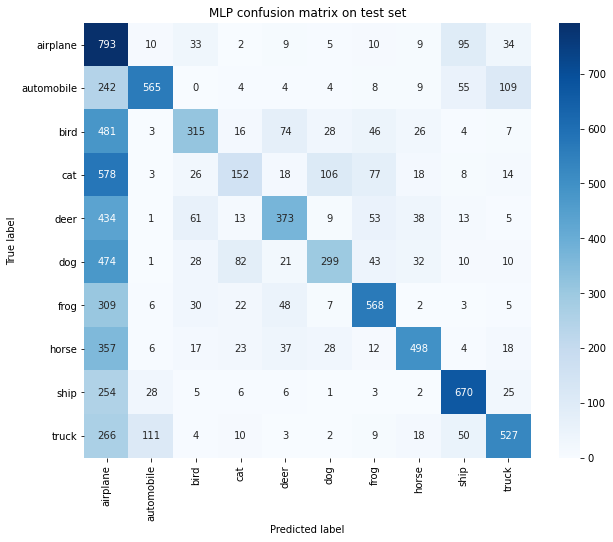

In [22]:
# Apply function to MLP model
show_confusion_matrix(mlp, y_pred_mlp, 'MLP', 'Blues')

We can see from the above confusion matrix that this model has a tendency to predict the **airplane** class, leading to a large number of images being wrongly classed as airplanes. The exact figures in the confusion matrix may change each time the model is run, but in general, it predicts ~80% of the airplane images correctly as airplanes, but then also predicts ~50% of the bird, cat, deer and dog images as airplanes too, and over 20% of the automobiles, frogs, horses, ships and trucks as airplanes. It's easy to see how it might mix up similar animals, or similar vehicles, but animals look quite different from airplanes, so it's surprising that this is the class it predicts the most.

It also struggles a bit with some other classes, where it's predicted 10% of the airplanes as ships, and ~12% of the trucks as automobiles. These are a bit more understandable, as they are quite similar.

We can also look at specific examples of correct and incorrect classifications. The `np.where` function can compare two arrays (i.e. the ground truth and the predictions) and identify the indexes where they match, or don't match, depending on the condition specified. This can then be passed into the function I have created below, which takes a random sample of 20 of these indexes and calls the `plot_images` function defined previously, to output the images as subplots.

In [23]:
def display_predictions(comparison, dataset, labels, comparison_name):

    # Get random sample of 20 indexes from the comparison list
    index_list = np.random.choice(comparison, size=20, replace=False)

    # Call plot_images function
    fig = plot_images(index_list, dataset, labels)

    # Apply plot title to fig
    plot_title = '20 random images of ' + comparison_name + ' classifications'
    fig.suptitle(plot_title, fontsize=16, y=0.95)

    return

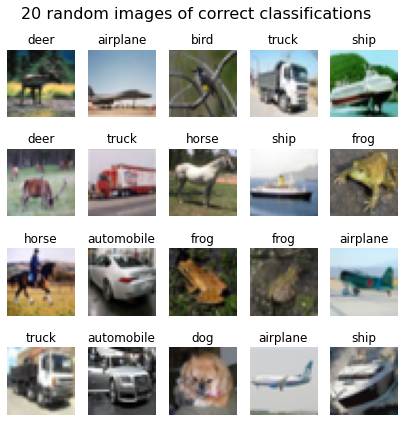

In [24]:
# Get comparison list of correct predictions
correct_mlp = np.where(y_pred_mlp==y_test)[0]

# Call function to display images
display_predictions(correct_mlp, X_test, y_pred_mlp, 'correct')

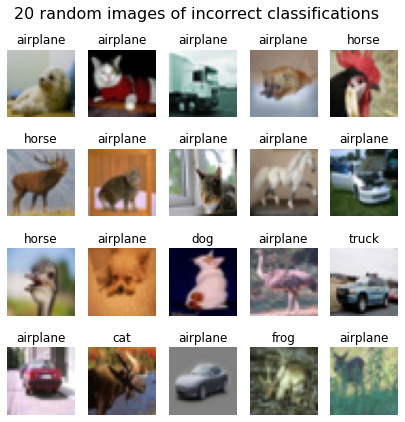

In [25]:
# Get comparison list of incorrect predictions
incorrect_mlp = np.where(y_pred_mlp != y_test)[0]

# Call function to display images
display_predictions(incorrect_mlp, X_test, y_pred_mlp, 'incorrect')

The images above are randomly generated each time the code is run, so it's difficult to talk about specific images. However, in general, these images support what we saw in the confusion matrix. In the 20 images of **correct classifications**, there's a good mix of classes, but proportionally more **airplanes** than other classes, because this is the class that the MLP is best at predicting.

In the 20 images of **incorrect classifications**, almost all of them are instances where the MLP has incorrectly predicted an airplane. Again, this is in line with the confusion matrix, because a very large proportion of the other classes were misclassified as airplanes.

## 4. Implementation of a CNN

Next, I will design and train a Convolutional Neural Network (CNN) on the CIFAR-10 dataset and compare its performance with the MLP model. 

As I did for the MLP, I performed experimentation on the CNN to find optimal values for a number of hyperparameters. I also decided on a number of fixed settings which I would not experiment with, which included keeping some parameter values from the MLP model. The **fixed settings** were:

* **Number of convolutional layers**: I decided on three layers because more convolutional layers with smaller kernels will generally perform better than fewer layers with larger kernels.
* Settings for the **fully connected layers**: I kept these the same as for the MLP: two layers with 300 neurons in each layer, the ReLU activation function and a `he_normal` intialiser.
* **Loss function**: I again used `sparse_categorical_crossentropy`, for the same reasons as before.
* **Optimiser**: I kept this the same as for the MLP.
* **Learning rate scheduler**: I kept this the same as for the MLP.

Having decided on these settings, I began the hyperparameter tuning process, using Keras Tuner to search through different values for:
* Number of kernels
* Kernel size
* Activation function

As for the MLP, only the final Keras Tuner search is shown commented-out below.

In [26]:
# # Keras tuner search with 2x values for filters, kernel size, activation function in Conv2D layers
# # Define the model builder function
# def model_builder_cnn(hp):

#   # 2 choices of activation function
#   activations=hp.Choice('activation', ['elu', 'relu'])

#   # Create the model with 2 options for kernel size and number of kernels, for each layer
#   model = keras.models.Sequential([
#             keras.layers.Conv2D(filters=hp.Choice('f_1', [32, 64]), kernel_size=hp.Choice('k_1', [5, 7]), activation=activations, padding="same", input_shape=[32, 32, 3]),
#             keras.layers.MaxPooling2D(2),
#             keras.layers.Conv2D(filters=hp.Choice('f_2', [256, 512]), kernel_size=hp.Choice('k_2', [3, 5]), activation=activations, padding="same"),
#             keras.layers.MaxPooling2D(2),
#             keras.layers.Conv2D(filters=hp.Choice('f_3', [512, 1024]), kernel_size=hp.Choice('k_3', [3, 5]), activation=activations, padding="same"),
#             keras.layers.MaxPooling2D(2),
#             keras.layers.Flatten(),
#             keras.layers.Dropout(rate=0.1),
#             keras.layers.BatchNormalization(),
#             keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
#             keras.layers.Dropout(rate=0.1),
#             keras.layers.BatchNormalization(),
#             keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
#             keras.layers.Dropout(rate=0.1),
#             keras.layers.BatchNormalization(),
#             keras.layers.Dense(10, activation="softmax")
#   ])
  
#   # Momentum optimiser
#   opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
#   model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"]) 

#   return model

# # Create the Hyperband tuner
# tuner_cnn = kt.Hyperband(model_builder_cnn,
#                      objective='val_accuracy',
#                      max_epochs=100,
#                      factor=3,
#                      overwrite=True)

# # Use tuner to search on training set and test on validation set
# tuner_cnn.search(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[])

# # Get a summary of top 10 results
# tuner_cnn.results_summary()


From this search, the model with the highest validation accuracy had the following hyperparameters:

* Kernel size: **5** for layer 1, **3** for layers 2 and 3
* Number of kernels: **32** for layer 1, **256** for layer 2, **512** for layer 3
* Activation function: **ReLU** for all layers.

Before implementing the CNN model with these settings, I will first create a new **checkpoint callback**, which will save the model in a new CNN directory. I will use the same **early stopping callback** that I created for the MLP.

In [27]:
# Checkpoint callback
checkpoint_cnn = keras.callbacks.ModelCheckpoint("Rattigan_Elise-CNN", save_best_only=True)

### 4.1 Implementing the model

The code to create the model with the optimal hyperparameters (described above) is shown below.

Originally, I ran the model with a Dropout rate of 0.1, the same as the MLP. However, I found that the model was quite badly overfitting the training set. I adjusted the **Dropout rate to 0.5** and ran the model again, and saw huge improvements. This is the model which is implemented below.

As before, the model is enclosed in an **if-else** statement to enable it to either be run from scratch, or to be loaded and trained for one more epoch. The code below also outputs a summary of the model's architecture and (if training the model from scratch) a graph of the learning curves.

In [28]:
# Allowing options to implement model from scratch, or existing model
if os.path.isdir("Rattigan_Elise-CNN"):

    # Load existing model
    cnn = keras.models.load_model("Rattigan_Elise-CNN")

    # Display architecture
    cnn.summary()

    # Train existing model for one more epoch, early stopping callback not required
    history_cnn = cnn.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid),
                  callbacks=[checkpoint_cnn, lr_performance])

else:
    # Create the model from scratch
    # Has 3 Conv2D layers, pooling and batch normalisation layers as specified in labsheet
    cnn = keras.models.Sequential([
            keras.layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding="same", input_shape=[32, 32, 3]),
            keras.layers.MaxPooling2D(2),
            keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
            keras.layers.MaxPooling2D(2),
            keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu", padding="same"),
            keras.layers.MaxPooling2D(2),
            keras.layers.Flatten(),
            keras.layers.Dropout(rate=0.5),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
            keras.layers.Dropout(rate=0.5),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
            keras.layers.Dropout(rate=0.5),
            keras.layers.BatchNormalization(),
            keras.layers.Dense(10, activation="softmax")
    ])

    # Display architecture
    cnn.summary()

    # Compile the model with optimizer and loss function same as MLP
    opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    cnn.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

    # Train the model and pass validation set to measure validation accuracy
    # Include early stopping, checkpoint and performance scheduler callbacks
    history_cnn = cnn.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
                  callbacks=[early_stopping_cb, checkpoint_cnn, lr_performance])
  
    # Inspect the learning curves
    pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
    plt.show()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       73984     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         1180160   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

The summary of the architecture in the output shows each of the convolutional layers, pooling layers and fully connected layers with dropout and batch normalization. Each **pooling layer** after the convolutional layers divides each spatial dimension by a factor of 2, because `pool_size=2`. This reduces the number of parameters at each layer by preserving only the strongest features, and therefore **reduces computing time and the risk of overfitting**.

In total, there are over 3 million trainable parameters in this model, which is triple the amount in the MLP, so it has three times as many calculations to process and is therefore quite a lot slower.

When the model is trained from scratch, we can see the training and validation loss and accuracy scores at each epoch. In the final few epochs, the validation accuracy is about 0.77, which is very close to the training accuracy of about 0.78 (when I ran the model). This means there is **very little evidence of overfitting**, which is thanks to the **increased dropout rate** that I included after running the model the first time.

### 4.2 Evaluating the model

I can now use the trained CNN model to make predictions on the test set, calculate the accuracy and F1 score and produce confusion matrices of the correct and incorrect classifications. I created these functions previously for the MLP, so will use these same functions for the CNN.

In [29]:
# Get F1 and accuracy scores for CNN
y_pred_cnn, accuracy_cnn, f1_cnn = get_scores(cnn, 'CNN')

The classification accuracy of the CNN on the test set is 0.785.
The average F1 score of the CNN on the test set is 0.752.


In general, the **accuracy score** of the CNN on the test set is around **0.77**. This is quite good, because it means the model is getting around 77% of the predictions correct.

The **F1 score** is around **0.75**, which means the precision and recall scores average out to about 0.75. This is definitely an improvement on the MLP and means that this CNN model has resulted in more true positive predictions. It is still not perfect, but better than the MLP, and definitely much better than random guessing would be able to achieve.

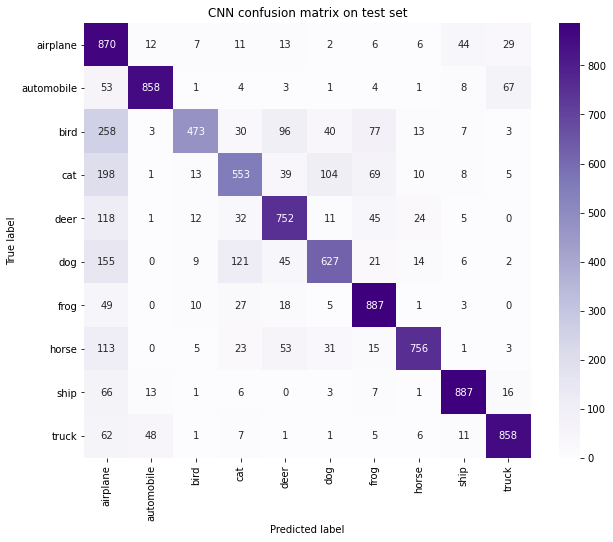

In [30]:
# Display confusion matrix for CNN
show_confusion_matrix(cnn, y_pred_cnn, 'CNN', 'Purples')

The confusion matrix above clearly shows that the CNN has **performed much better than the MLP** on the test set. It still has a tendency to predict the **airplane** class, but much less frequently than the MLP. It has predicted around 25% of birds, 20% of cats, 15% of deers and 10% of dogs and frogs as airplanes (numbers may change).

It appears to struggle a little with the different classes of animals, particularly with birds, incorrectly predicting these as deer, dogs or frogs, and also with cats, incorrectly predicting these as dogs or frogs, mostly. However, this has only happened for around 6 - 10% of the instances in these classes, so in general, this model is a pretty good predictor.

We can use the functions I created previously to look at specific examples of correct and incorrect classifications.

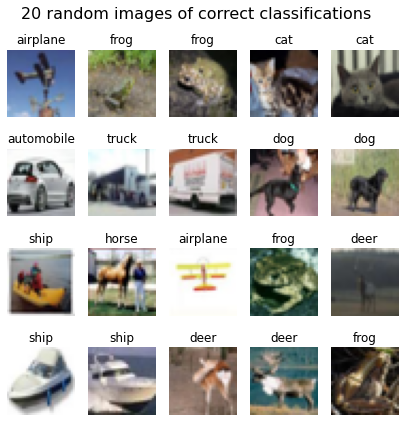

In [31]:
# Get comparison list of correct predictions
correct_cnn = np.where(y_pred_cnn==y_test)[0]

# Call function to display images
display_predictions(correct_cnn, X_test, y_pred_cnn, 'correct')

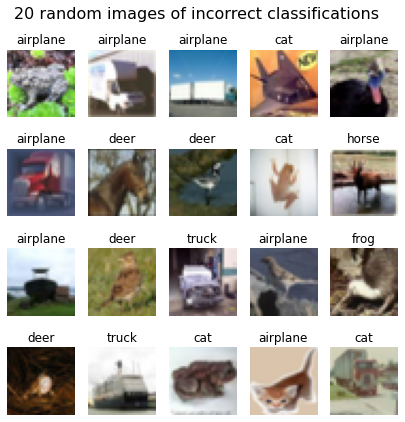

In [32]:
# Get comparison list of incorrect predictions
incorrect_cnn = np.where(y_pred_cnn != y_test)[0]

# Call function to display images
display_predictions(incorrect_cnn, X_test, y_pred_cnn, 'incorrect')

Again, because the images are randomly generated, it's hard to talk about them specifically. But in general, we can see that airplanes don't tend to dominate either the correct classifications or incorrect classifications quite as much as they did for the MLP. So in the **incorrect classifications**, there are a lot of images (mostly animals) that have been misclassified as airplanes, but also some examples where they have been misclassified as cats or birds.


## 5. Comparison and Summary

Looking at the two models together, we can compare their performance on predicting images from the CIFAR-10 dataset. Firstly, we can compare the **accuracy** of the two models. These did vary each time I ran the models, but on average, the **MLP** scored around **0.55** accuracy on the test set, and the **CNN** scored around **0.78**. This means the MLP got around 55% correct classifications, just over half, while the CNN got around 78%, which is over three quarters. It is still not perfect, but has substantially improved accuracy over the MLP, so is clearly better at discriminating between the different classes.

When we compare the **confusion matrices**, there are obvious differences between the two models. I've explained the confusions matrices in greater detail in their repective sections, but overall, the MLP had a much greater tendency to predict **airplanes** than the CNN. It incorrectly classified large proportions of the animal classes as airplanes, and some of the ships, trucks and automobiles. It did still get many correct classifications, but its F1 score was negatively affected by this airplane prediction problem. The **CNN** still had some trouble with a few of the animal classes, predicting around 20% of them as airplanes, but this was much fewer than the MLP.

However, when it came to actually predicting airplanes as airplanes, both models did very well. The MLP correctly classified around 80% of airplanes, and the CNN correctly classified around 86% of airplanes. So both models did **similarly well at recognising airplane images**.

Aside from airplanes, other classes where the CNN worked better than the MLP were:
* Automobiles. The MLP classed more of these as trucks than the CNN did.
* Trucks. The MLP classed more of these as automobiles and ships than the CNN did.
* Frogs and birds. The MLP classed more of these as deer than the CNN did.

Interestingly, the CNN actually performed worse than the MLP in the following areas:
* The CNN incorrectly classed cats as dogs around twice as much as the MLP
* The CNN incorrectly classed horses as dogs more than the MLP

In conclusion, the CNN definitely seems to be a more robust and accurate model than the MLP. It is far better at recognising features in the images and discriminating between the different classes. Its good performance on the test set means it is able to generalise to unseen data and make good predictions. While it does still have trouble with some of the images, it showed a marked improvement over the MLP.